In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.CIFAR as CIFAR
from utils.datasetsUtils.taskManager import IncrementalTaskClassification, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
import networks.continual_learning_beta as continual_learning_beta

from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
config = configClasses.DefaultConfig()
config.L1_REG = 0
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.SAVE_PATH = './models/mt_kaf_tecnique_comparison_new'
config.IS_CONVOLUTIONAL = True
config.USE_CL = False
config.MODEL_NAME = ''
config.NEXT_TASK_EPOCHS = None
config.NEXT_TASK_LR = None
config.OPTIMIZER = 'Adam'
# config.IS_INCREMENTAL = True
# config.DEVICE = 'cpu'
print(config)

CONFIG PARAMETERS
BATCH_SIZE: 32
CL_PAR: {'sample_size': 250, 'penalty_importance': 1000.0}
CL_TEC: <class 'networks.continual_learning.EWC'>
DEVICE: cuda
EPOCHS: 10
IS_CONVOLUTIONAL: True
IS_INCREMENTAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
NEXT_TASK_EPOCHS: None
NEXT_TASK_LR: None
OPTIMIZER: Adam
RUN_NAME: default
SAVE_PATH: ./models/mt_kaf_tecnique_comparison_new
USE_CL: False
USE_TENSORBOARD: True



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

dataset = CIFAR.Cifar10('../data/cifar10', download=True, transform=transform, 
                        task_manager=IncrementalTaskClassification(2),
                        force_download=False, train_split=0.8, target_transform=None)
dataset.load_dataset()
print(len(dataset.Y))

../data/cifar10/download
60000


In [7]:
net = Kafnet.synCNN(10, kernel='softplus', D=15, boundary=3, trainable_dict=False,
                    topology=[int(32*0.7),  int(64*0.7)])

In [8]:
results = []
experiments = [('no_cont_learning', None), 
               ('embedding', continual_learning_beta.embedding),
               ('ewc', continual_learning.OnlineEWC),
               ('gem', continual_learning.GEM),]

In [9]:
for name, tec in experiments:
    print(name)
    
    n = deepcopy(net)
    c = deepcopy(config)
    
    c.MODEL_NAME = name

    if name == 'gem':
        c.CL_PAR['margin'] = 0.5
        c.CL_PAR['sample_size'] = 100
        c.USE_CL = True
        c.IS_INCREMENTAL = True
    elif name == 'ewc':
        c.CL_PAR['penalty_importance'] = 1e2
        c.USE_CL = True
        c.IS_INCREMENTAL = True
    elif name == 'embedding':
        c.CL_PAR = {'penalty_importance': 1, 'weights_type': 'distance', 'sample_size': 30, 'distance': 'cosine'}
        c.USE_CL = True
        c.IS_INCREMENTAL = True

    c.CL_TEC = tec
    trainer = Trainer(n, deepcopy(dataset), c, save_modality=2, verbose=False)

    r = trainer.load()
    if not r:
        r = trainer.all_tasks()
#     print(r)
    results.append((name, r))
    
    del trainer
    del n

no_cont_learning
embedding
0 [0.8879166666666667]
0 [0.8879166666666667, 0.9179166666666667]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125, 0.9579166666666666]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667

0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125, 0.9579166666666666, 0.95875, 0.915, 0.9308333333333333, 0.9333333333333333, 0.9283333333333333, 0.93, 0.9320833333333334, 0.9329166666666666, 0.935, 0.9375, 0.9416666666666667, 0.91875, 0.9191666666666667, 0.9054166666666666, 0.9229166666666667, 0.91875, 0.9016666666666666, 0.9233333333333333, 0.93375]
1 [0.7825, 0.79, 0.8295833333333333, 0.8183333333333334, 0.8383333333333334, 0.845, 0.84375, 0.8445833333333334, 0.8370833333333333, 0.83875, 0.7575, 0.765, 0.76125, 0.755, 0.7175, 0.6820833333333334, 0.7108333333333333, 0.6975]
2 [0.8325, 0.86125, 0.87875, 0.8754166666666666, 0.8533333333333334, 0.8025, 0.89375, 0.8870833333333333]
0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125, 0.9579166666666666, 0.95875, 0.915, 0.9308333333333333, 0.9333333333333333, 0.9

0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125, 0.9579166666666666, 0.95875, 0.915, 0.9308333333333333, 0.9333333333333333, 0.9283333333333333, 0.93, 0.9320833333333334, 0.9329166666666666, 0.935, 0.9375, 0.9416666666666667, 0.91875, 0.9191666666666667, 0.9054166666666666, 0.9229166666666667, 0.91875, 0.9016666666666666, 0.9233333333333333, 0.93375, 0.8979166666666667, 0.9091666666666667, 0.9016666666666666, 0.9241666666666667, 0.9216666666666666, 0.9283333333333333, 0.9275, 0.9333333333333333, 0.9325]
1 [0.7825, 0.79, 0.8295833333333333, 0.8183333333333334, 0.8383333333333334, 0.845, 0.84375, 0.8445833333333334, 0.8370833333333333, 0.83875, 0.7575, 0.765, 0.76125, 0.755, 0.7175, 0.6820833333333334, 0.7108333333333333, 0.6975, 0.6816666666666666, 0.7033333333333334, 0.5979166666666667, 0.6058333333333333, 0.6066666666666667, 0.6495833333333333, 0.6254166666666666, 0.6529166666666667, 0.62541666

0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125, 0.9579166666666666, 0.95875, 0.915, 0.9308333333333333, 0.9333333333333333, 0.9283333333333333, 0.93, 0.9320833333333334, 0.9329166666666666, 0.935, 0.9375, 0.9416666666666667, 0.91875, 0.9191666666666667, 0.9054166666666666, 0.9229166666666667, 0.91875, 0.9016666666666666, 0.9233333333333333, 0.93375, 0.8979166666666667, 0.9091666666666667, 0.9016666666666666, 0.9241666666666667, 0.9216666666666666, 0.9283333333333333, 0.9275, 0.9333333333333333, 0.9325, 0.9329166666666666, 0.93125, 0.93625, 0.8195833333333333, 0.9029166666666667, 0.9004166666666666]
1 [0.7825, 0.79, 0.8295833333333333, 0.8183333333333334, 0.8383333333333334, 0.845, 0.84375, 0.8445833333333334, 0.8370833333333333, 0.83875, 0.7575, 0.765, 0.76125, 0.755, 0.7175, 0.6820833333333334, 0.7108333333333333, 0.6975, 0.6816666666666666, 0.7033333333333334, 0.5979166666666667, 0.6058333333

0 [0.8879166666666667, 0.9179166666666667, 0.9354166666666667, 0.9258333333333333, 0.9454166666666667, 0.9491666666666667, 0.95875, 0.95125, 0.9579166666666666, 0.95875, 0.915, 0.9308333333333333, 0.9333333333333333, 0.9283333333333333, 0.93, 0.9320833333333334, 0.9329166666666666, 0.935, 0.9375, 0.9416666666666667, 0.91875, 0.9191666666666667, 0.9054166666666666, 0.9229166666666667, 0.91875, 0.9016666666666666, 0.9233333333333333, 0.93375, 0.8979166666666667, 0.9091666666666667, 0.9016666666666666, 0.9241666666666667, 0.9216666666666666, 0.9283333333333333, 0.9275, 0.9333333333333333, 0.9325, 0.9329166666666666, 0.93125, 0.93625, 0.8195833333333333, 0.9029166666666667, 0.9004166666666666, 0.9008333333333334, 0.9020833333333333, 0.9179166666666667, 0.9141666666666667, 0.9241666666666667]
1 [0.7825, 0.79, 0.8295833333333333, 0.8183333333333334, 0.8383333333333334, 0.845, 0.84375, 0.8445833333333334, 0.8370833333333333, 0.83875, 0.7575, 0.765, 0.76125, 0.755, 0.7175, 0.6820833333333334, 

/media/jary/DATA/Uni/tesi/codice/utils/datasetsUtils/dataset.py:53: UserWarning: No more tasks...
  warnings.warn("No more tasks...")


0 [0.8858333333333334]
0 [0.8858333333333334, 0.9208333333333333]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334, 0.9566666666666667]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 

0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334, 0.9566666666666667, 0.815, 0.8929166666666667, 0.7866666666666666, 0.8325, 0.8570833333333333, 0.8516666666666667, 0.7483333333333333, 0.8666666666666667, 0.8958333333333334, 0.85875, 0.7245833333333334, 0.7175, 0.7391666666666666, 0.6683333333333333, 0.7004166666666667, 0.7216666666666667, 0.735]
1 [0.6991666666666667, 0.7066666666666667, 0.6816666666666666, 0.705, 0.7145833333333333, 0.71625, 0.7308333333333333, 0.7229166666666667, 0.7270833333333333, 0.69125, 0.6254166666666666, 0.6308333333333334, 0.6441666666666667, 0.5858333333333333, 0.5708333333333333, 0.5625, 0.5645833333333333]
2 [0.7904166666666667, 0.7766666666666666, 0.8, 0.7925, 0.7891666666666667, 0.7995833333333333, 0.8041666666666667]
0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.953333333333333

0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334, 0.9566666666666667, 0.815, 0.8929166666666667, 0.7866666666666666, 0.8325, 0.8570833333333333, 0.8516666666666667, 0.7483333333333333, 0.8666666666666667, 0.8958333333333334, 0.85875, 0.7245833333333334, 0.7175, 0.7391666666666666, 0.6683333333333333, 0.7004166666666667, 0.7216666666666667, 0.735, 0.7641666666666667, 0.80375, 0.7795833333333333, 0.6904166666666667, 0.6420833333333333, 0.545, 0.3225, 0.5020833333333333]
1 [0.6991666666666667, 0.7066666666666667, 0.6816666666666666, 0.705, 0.7145833333333333, 0.71625, 0.7308333333333333, 0.7229166666666667, 0.7270833333333333, 0.69125, 0.6254166666666666, 0.6308333333333334, 0.6441666666666667, 0.5858333333333333, 0.5708333333333333, 0.5625, 0.5645833333333333, 0.5729166666666666, 0.5429166666666667, 0.5533333333333333, 0.23875, 0.15166666666666667, 0.11583333333333333, 0.10583333333333333, 0.1

0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334, 0.9566666666666667, 0.815, 0.8929166666666667, 0.7866666666666666, 0.8325, 0.8570833333333333, 0.8516666666666667, 0.7483333333333333, 0.8666666666666667, 0.8958333333333334, 0.85875, 0.7245833333333334, 0.7175, 0.7391666666666666, 0.6683333333333333, 0.7004166666666667, 0.7216666666666667, 0.735, 0.7641666666666667, 0.80375, 0.7795833333333333, 0.6904166666666667, 0.6420833333333333, 0.545, 0.3225, 0.5020833333333333, 0.5779166666666666, 0.6516666666666666, 0.5729166666666666, 0.5466666666666666, 0.5795833333333333, 0.6325]
1 [0.6991666666666667, 0.7066666666666667, 0.6816666666666666, 0.705, 0.7145833333333333, 0.71625, 0.7308333333333333, 0.7229166666666667, 0.7270833333333333, 0.69125, 0.6254166666666666, 0.6308333333333334, 0.6441666666666667, 0.5858333333333333, 0.5708333333333333, 0.5625, 0.5645833333333333, 0.5729166666666666, 0.54291

0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334, 0.9566666666666667, 0.815, 0.8929166666666667, 0.7866666666666666, 0.8325, 0.8570833333333333, 0.8516666666666667, 0.7483333333333333, 0.8666666666666667, 0.8958333333333334, 0.85875, 0.7245833333333334, 0.7175, 0.7391666666666666, 0.6683333333333333, 0.7004166666666667, 0.7216666666666667, 0.735, 0.7641666666666667, 0.80375, 0.7795833333333333, 0.6904166666666667, 0.6420833333333333, 0.545, 0.3225, 0.5020833333333333, 0.5779166666666666, 0.6516666666666666, 0.5729166666666666, 0.5466666666666666, 0.5795833333333333, 0.6325, 0.62, 0.5366666666666666, 0.5183333333333333, 0.56375, 0.47583333333333333]
1 [0.6991666666666667, 0.7066666666666667, 0.6816666666666666, 0.705, 0.7145833333333333, 0.71625, 0.7308333333333333, 0.7229166666666667, 0.7270833333333333, 0.69125, 0.6254166666666666, 0.6308333333333334, 0.6441666666666667, 0.5858333333333333,

0 [0.8858333333333334, 0.9208333333333333, 0.9383333333333334, 0.9425, 0.95, 0.9533333333333334, 0.9545833333333333, 0.96125, 0.9533333333333334, 0.9566666666666667, 0.815, 0.8929166666666667, 0.7866666666666666, 0.8325, 0.8570833333333333, 0.8516666666666667, 0.7483333333333333, 0.8666666666666667, 0.8958333333333334, 0.85875, 0.7245833333333334, 0.7175, 0.7391666666666666, 0.6683333333333333, 0.7004166666666667, 0.7216666666666667, 0.735, 0.7641666666666667, 0.80375, 0.7795833333333333, 0.6904166666666667, 0.6420833333333333, 0.545, 0.3225, 0.5020833333333333, 0.5779166666666666, 0.6516666666666666, 0.5729166666666666, 0.5466666666666666, 0.5795833333333333, 0.6325, 0.62, 0.5366666666666666, 0.5183333333333333, 0.56375, 0.47583333333333333, 0.52, 0.54, 0.5720833333333334, 0.59875]
1 [0.6991666666666667, 0.7066666666666667, 0.6816666666666666, 0.705, 0.7145833333333333, 0.71625, 0.7308333333333333, 0.7229166666666667, 0.7270833333333333, 0.69125, 0.6254166666666666, 0.6308333333333334

0 [0.8820833333333333, 0.91125, 0.9333333333333333, 0.9379166666666666, 0.94875, 0.9454166666666667, 0.9445833333333333, 0.9491666666666667, 0.9504166666666667, 0.9533333333333334, 0.9575, 0.9483333333333334, 0.9541666666666667, 0.95625, 0.9575, 0.955, 0.9441666666666667, 0.955, 0.9525, 0.9575, 0.9475, 0.9516666666666667, 0.9529166666666666, 0.95375]
1 [0.7445833333333334, 0.7279166666666667, 0.7791666666666667, 0.78375, 0.7379166666666667, 0.7791666666666667, 0.7475, 0.7729166666666667, 0.785, 0.78875, 0.8020833333333334, 0.81, 0.8141666666666667, 0.7891666666666667]
2 [0.76875, 0.79875, 0.7929166666666667, 0.7295833333333334]
0 [0.8820833333333333, 0.91125, 0.9333333333333333, 0.9379166666666666, 0.94875, 0.9454166666666667, 0.9445833333333333, 0.9491666666666667, 0.9504166666666667, 0.9533333333333334, 0.9575, 0.9483333333333334, 0.9541666666666667, 0.95625, 0.9575, 0.955, 0.9441666666666667, 0.955, 0.9525, 0.9575, 0.9475, 0.9516666666666667, 0.9529166666666666, 0.95375, 0.952083333

0 [0.8820833333333333, 0.91125, 0.9333333333333333, 0.9379166666666666, 0.94875, 0.9454166666666667, 0.9445833333333333, 0.9491666666666667, 0.9504166666666667, 0.9533333333333334, 0.9575, 0.9483333333333334, 0.9541666666666667, 0.95625, 0.9575, 0.955, 0.9441666666666667, 0.955, 0.9525, 0.9575, 0.9475, 0.9516666666666667, 0.9529166666666666, 0.95375, 0.9520833333333333, 0.9454166666666667, 0.9470833333333334, 0.9479166666666666, 0.9416666666666667, 0.9395833333333333, 0.9470833333333334, 0.9520833333333333, 0.9491666666666667, 0.9341666666666667]
1 [0.7445833333333334, 0.7279166666666667, 0.7791666666666667, 0.78375, 0.7379166666666667, 0.7791666666666667, 0.7475, 0.7729166666666667, 0.785, 0.78875, 0.8020833333333334, 0.81, 0.8141666666666667, 0.7891666666666667, 0.8141666666666667, 0.81375, 0.8175, 0.8225, 0.81875, 0.8120833333333334, 0.8191666666666667, 0.8320833333333333, 0.825, 0.8166666666666667]
2 [0.76875, 0.79875, 0.7929166666666667, 0.7295833333333334, 0.8, 0.7979166666666667

0 [0.8820833333333333, 0.91125, 0.9333333333333333, 0.9379166666666666, 0.94875, 0.9454166666666667, 0.9445833333333333, 0.9491666666666667, 0.9504166666666667, 0.9533333333333334, 0.9575, 0.9483333333333334, 0.9541666666666667, 0.95625, 0.9575, 0.955, 0.9441666666666667, 0.955, 0.9525, 0.9575, 0.9475, 0.9516666666666667, 0.9529166666666666, 0.95375, 0.9520833333333333, 0.9454166666666667, 0.9470833333333334, 0.9479166666666666, 0.9416666666666667, 0.9395833333333333, 0.9470833333333334, 0.9520833333333333, 0.9491666666666667, 0.9341666666666667, 0.9404166666666667, 0.94375, 0.9420833333333334, 0.9429166666666666, 0.9408333333333333, 0.9458333333333333]
1 [0.7445833333333334, 0.7279166666666667, 0.7791666666666667, 0.78375, 0.7379166666666667, 0.7791666666666667, 0.7475, 0.7729166666666667, 0.785, 0.78875, 0.8020833333333334, 0.81, 0.8141666666666667, 0.7891666666666667, 0.8141666666666667, 0.81375, 0.8175, 0.8225, 0.81875, 0.8120833333333334, 0.8191666666666667, 0.8320833333333333, 0.

0 [0.8820833333333333, 0.91125, 0.9333333333333333, 0.9379166666666666, 0.94875, 0.9454166666666667, 0.9445833333333333, 0.9491666666666667, 0.9504166666666667, 0.9533333333333334, 0.9575, 0.9483333333333334, 0.9541666666666667, 0.95625, 0.9575, 0.955, 0.9441666666666667, 0.955, 0.9525, 0.9575, 0.9475, 0.9516666666666667, 0.9529166666666666, 0.95375, 0.9520833333333333, 0.9454166666666667, 0.9470833333333334, 0.9479166666666666, 0.9416666666666667, 0.9395833333333333, 0.9470833333333334, 0.9520833333333333, 0.9491666666666667, 0.9341666666666667, 0.9404166666666667, 0.94375, 0.9420833333333334, 0.9429166666666666, 0.9408333333333333, 0.9458333333333333, 0.9370833333333334, 0.9341666666666667, 0.9379166666666666, 0.9279166666666666, 0.9279166666666666]
1 [0.7445833333333334, 0.7279166666666667, 0.7791666666666667, 0.78375, 0.7379166666666667, 0.7791666666666667, 0.7475, 0.7729166666666667, 0.785, 0.78875, 0.8020833333333334, 0.81, 0.8141666666666667, 0.7891666666666667, 0.81416666666666

0 [0.8820833333333333, 0.91125, 0.9333333333333333, 0.9379166666666666, 0.94875, 0.9454166666666667, 0.9445833333333333, 0.9491666666666667, 0.9504166666666667, 0.9533333333333334, 0.9575, 0.9483333333333334, 0.9541666666666667, 0.95625, 0.9575, 0.955, 0.9441666666666667, 0.955, 0.9525, 0.9575, 0.9475, 0.9516666666666667, 0.9529166666666666, 0.95375, 0.9520833333333333, 0.9454166666666667, 0.9470833333333334, 0.9479166666666666, 0.9416666666666667, 0.9395833333333333, 0.9470833333333334, 0.9520833333333333, 0.9491666666666667, 0.9341666666666667, 0.9404166666666667, 0.94375, 0.9420833333333334, 0.9429166666666666, 0.9408333333333333, 0.9458333333333333, 0.9370833333333334, 0.9341666666666667, 0.9379166666666666, 0.9279166666666666, 0.9279166666666666, 0.9225, 0.9341666666666667, 0.9325, 0.9358333333333333]
1 [0.7445833333333334, 0.7279166666666667, 0.7791666666666667, 0.78375, 0.7379166666666667, 0.7791666666666667, 0.7475, 0.7729166666666667, 0.785, 0.78875, 0.8020833333333334, 0.81, 

In [10]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics'])
    print()

RESULTS
no_cont_learning {'fwt': 0.0, 'bwt': -0.907, 'remembering': 0.09299999999999997, 'pbwt': 0, 'accuracy': 0.30622222222222223}

embedding {'fwt': 0.4024166666666666, 'bwt': -0.1065, 'remembering': 0.8935, 'pbwt': 0, 'accuracy': 0.8436944444444444}

ewc {'fwt': 0.4425, 'bwt': -0.25025000000000003, 'remembering': 0.7497499999999999, 'pbwt': 0, 'accuracy': 0.6789444444444446}

gem {'fwt': 0.2939583333333333, 'bwt': 0.019333333333333324, 'remembering': 1, 'pbwt': 0.019333333333333324, 'accuracy': 0.8791944444444445}



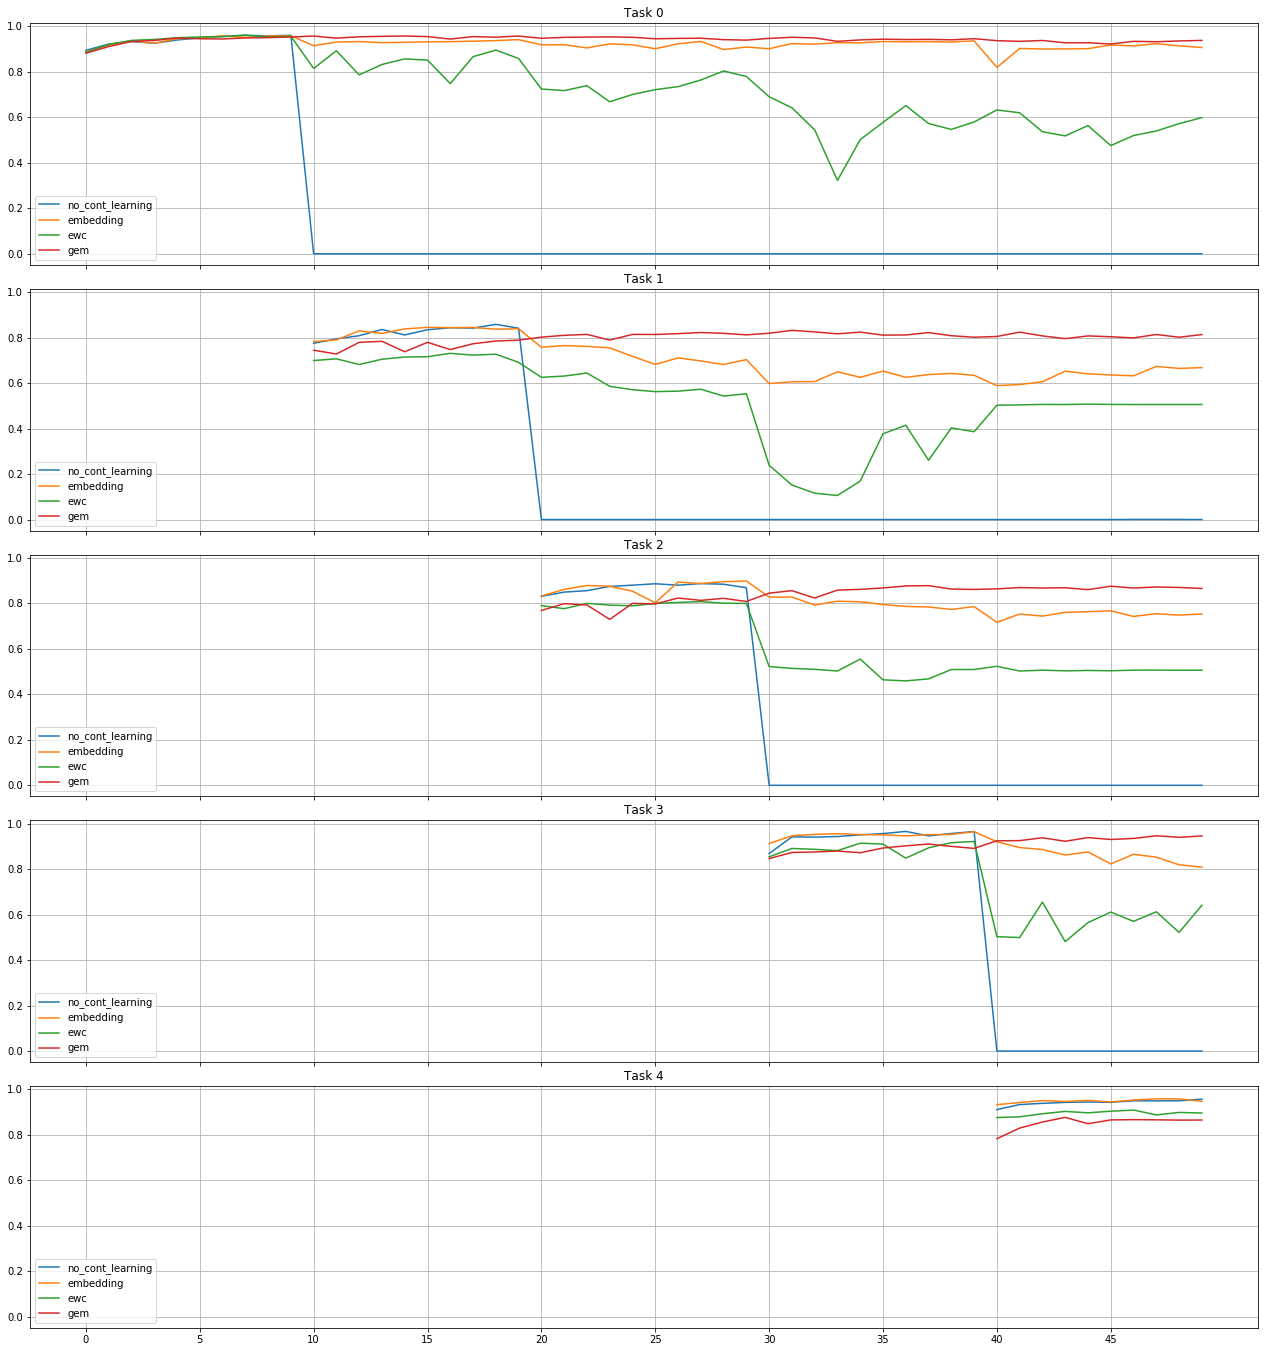

In [11]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=n_task, ncols=1, figsize=(22, 24), sharex=True, sharey=True)
    
for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]
        #no_ewt = metrics_no_ewt['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        #ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 

        ax[i].plot(x, com['accuracy'], label=name)
        #ax.plot(x, no_ewt['accuracy'], label='online ewt')

        ax[i].set_xticks(range(0, tot_epochs, 5),minor=False)

        ax[i].set_title("Task {}".format(task))
        ax[i].legend(loc="lower left")
        ax[i].grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)


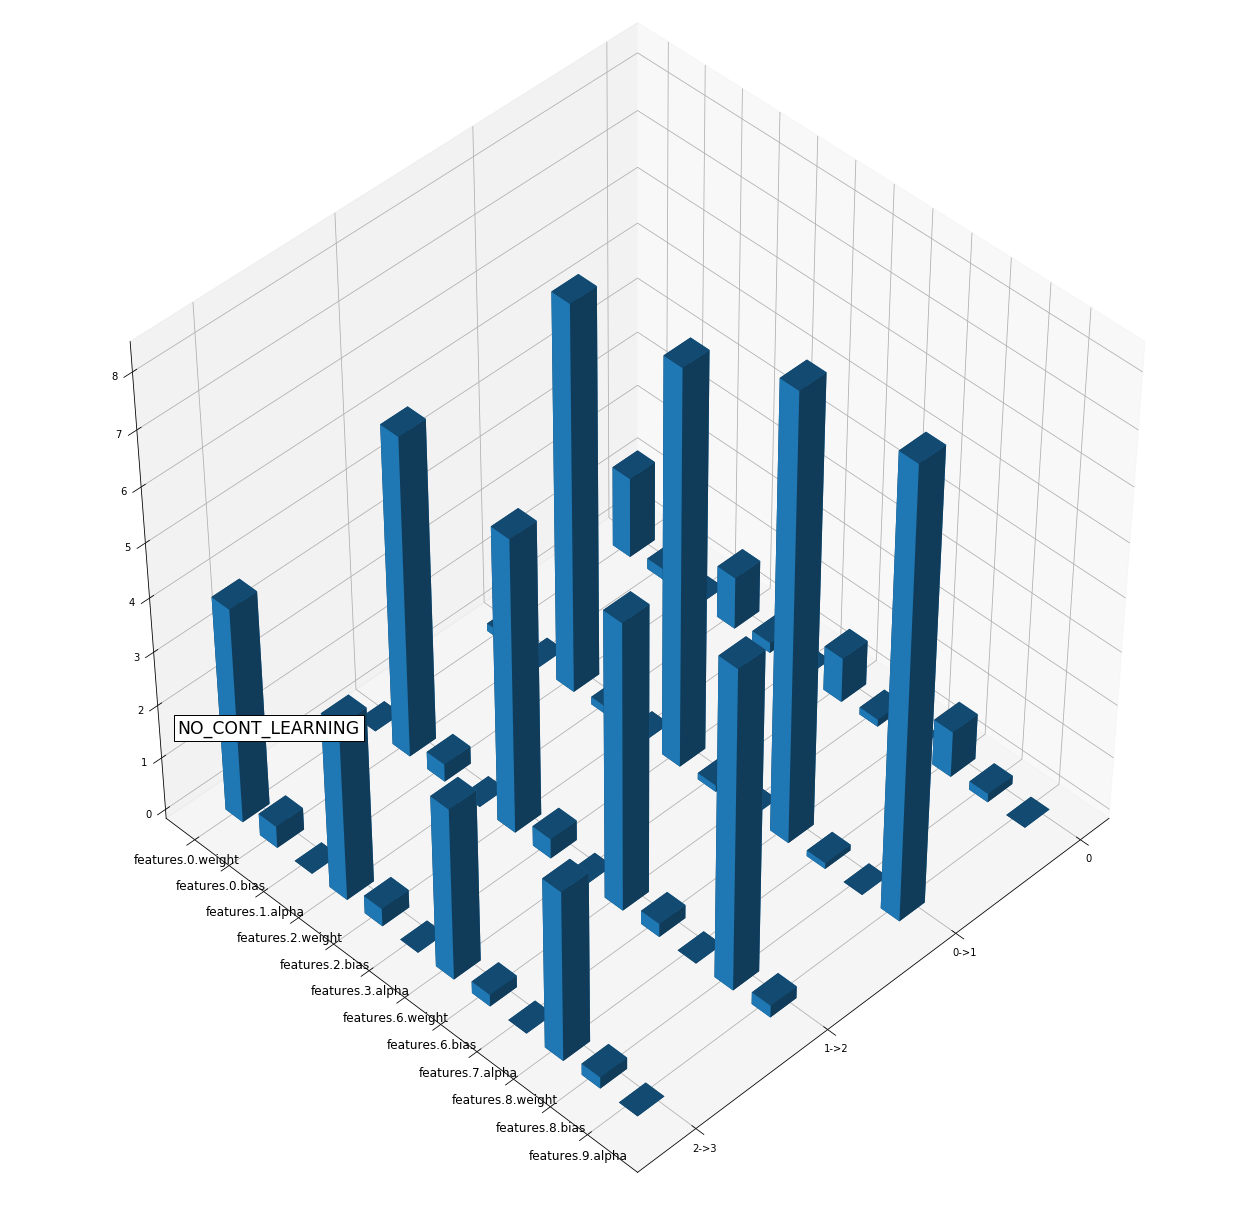

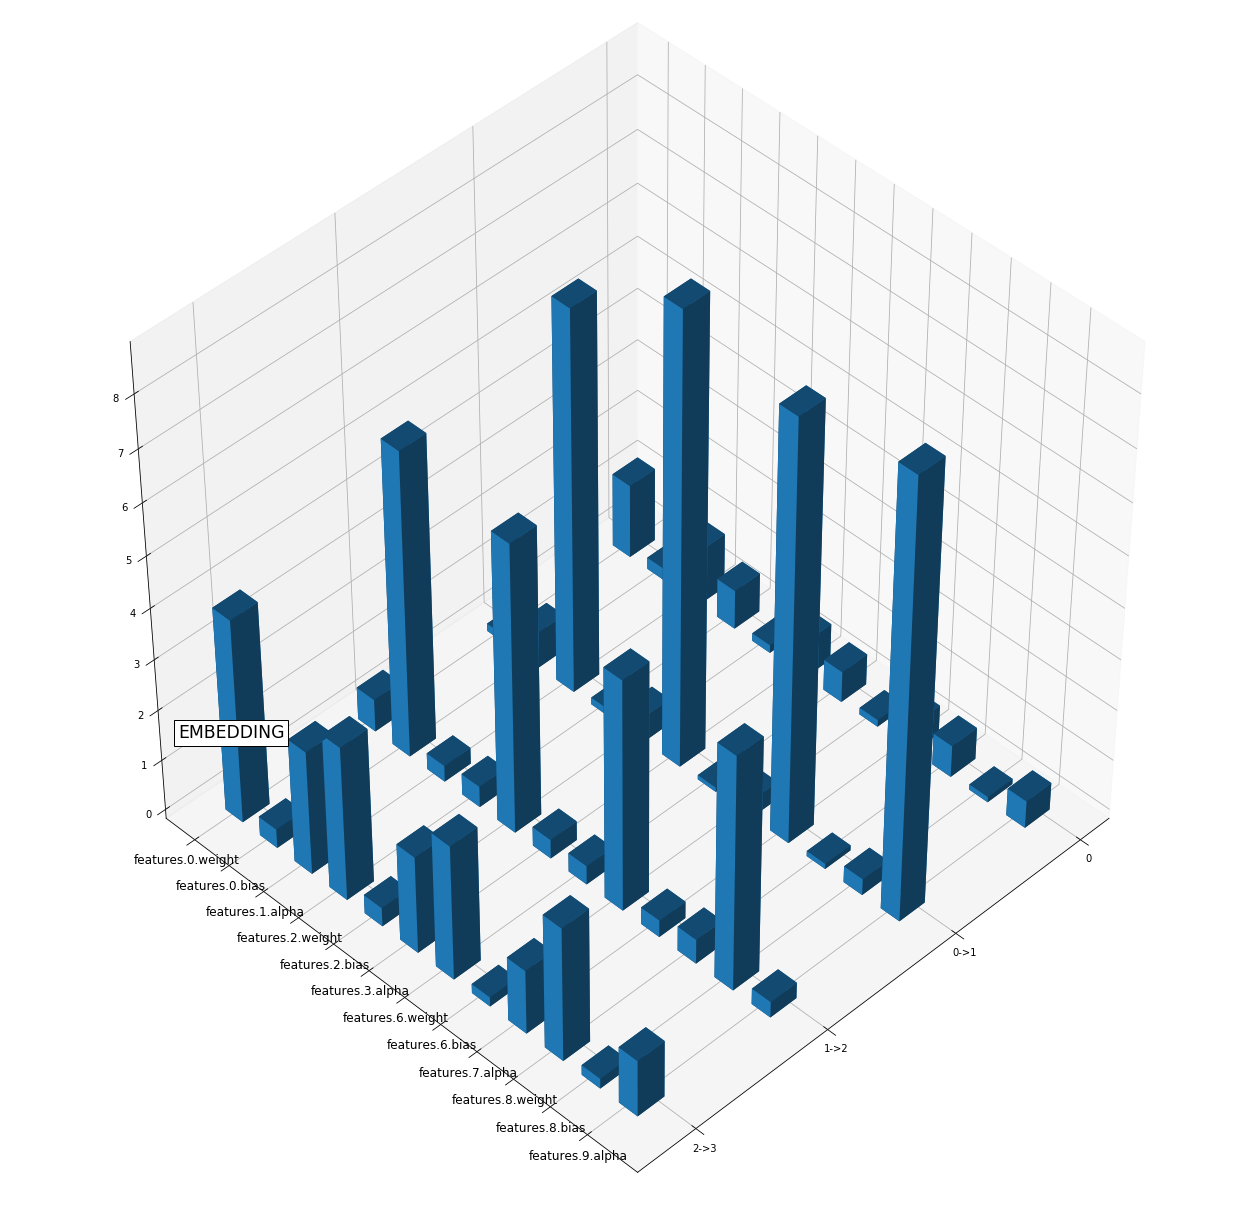

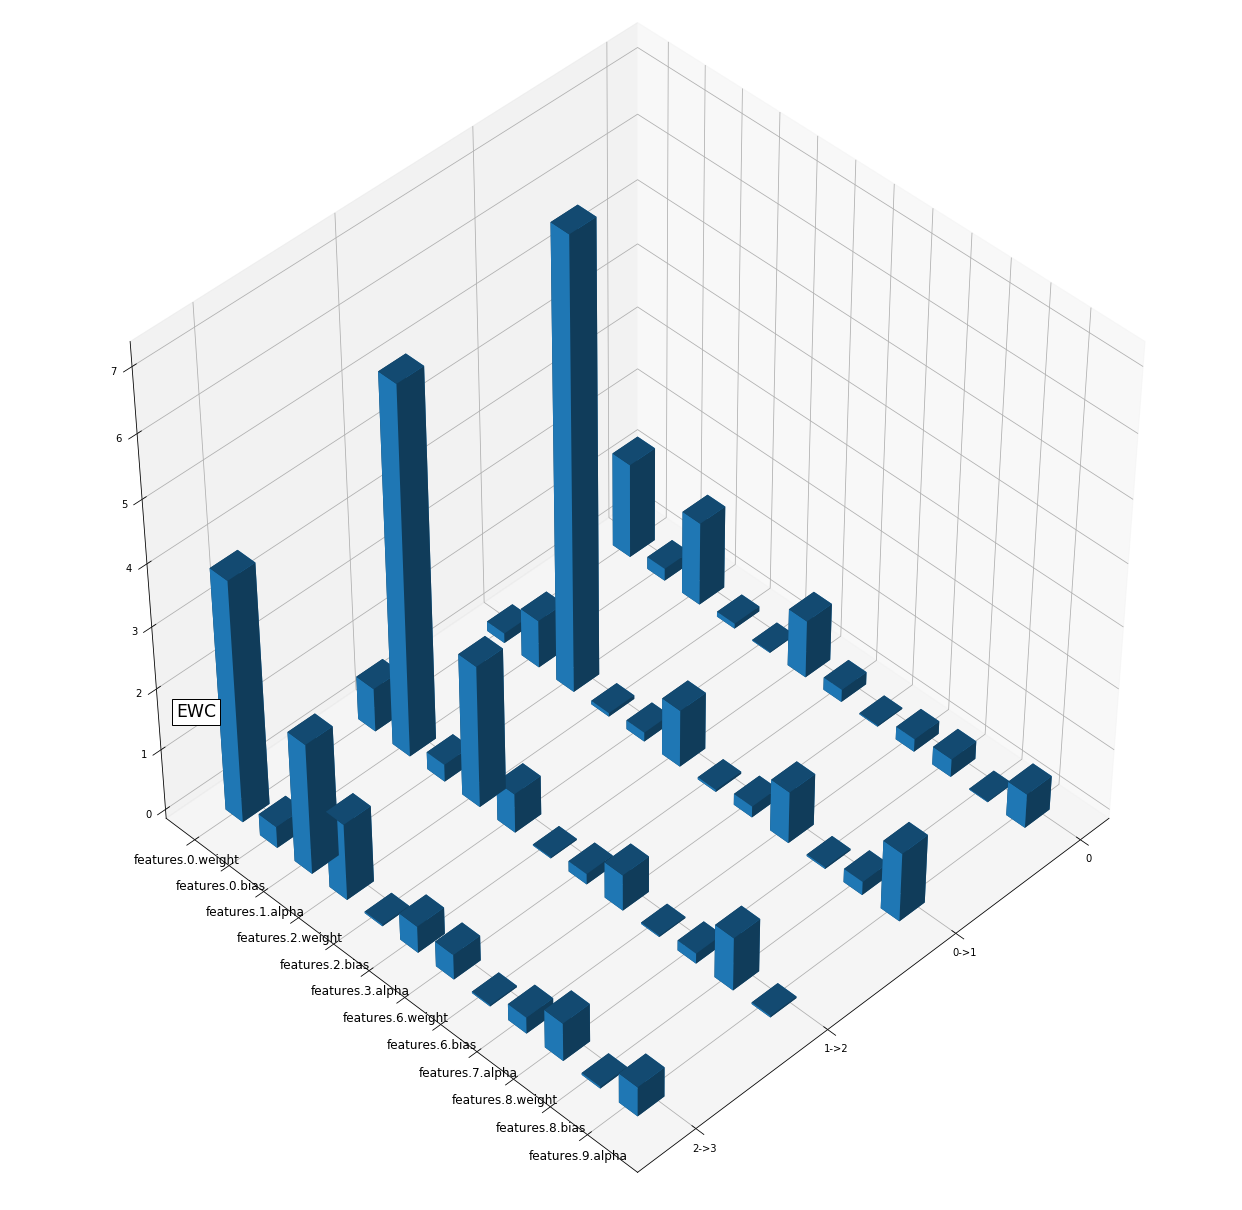

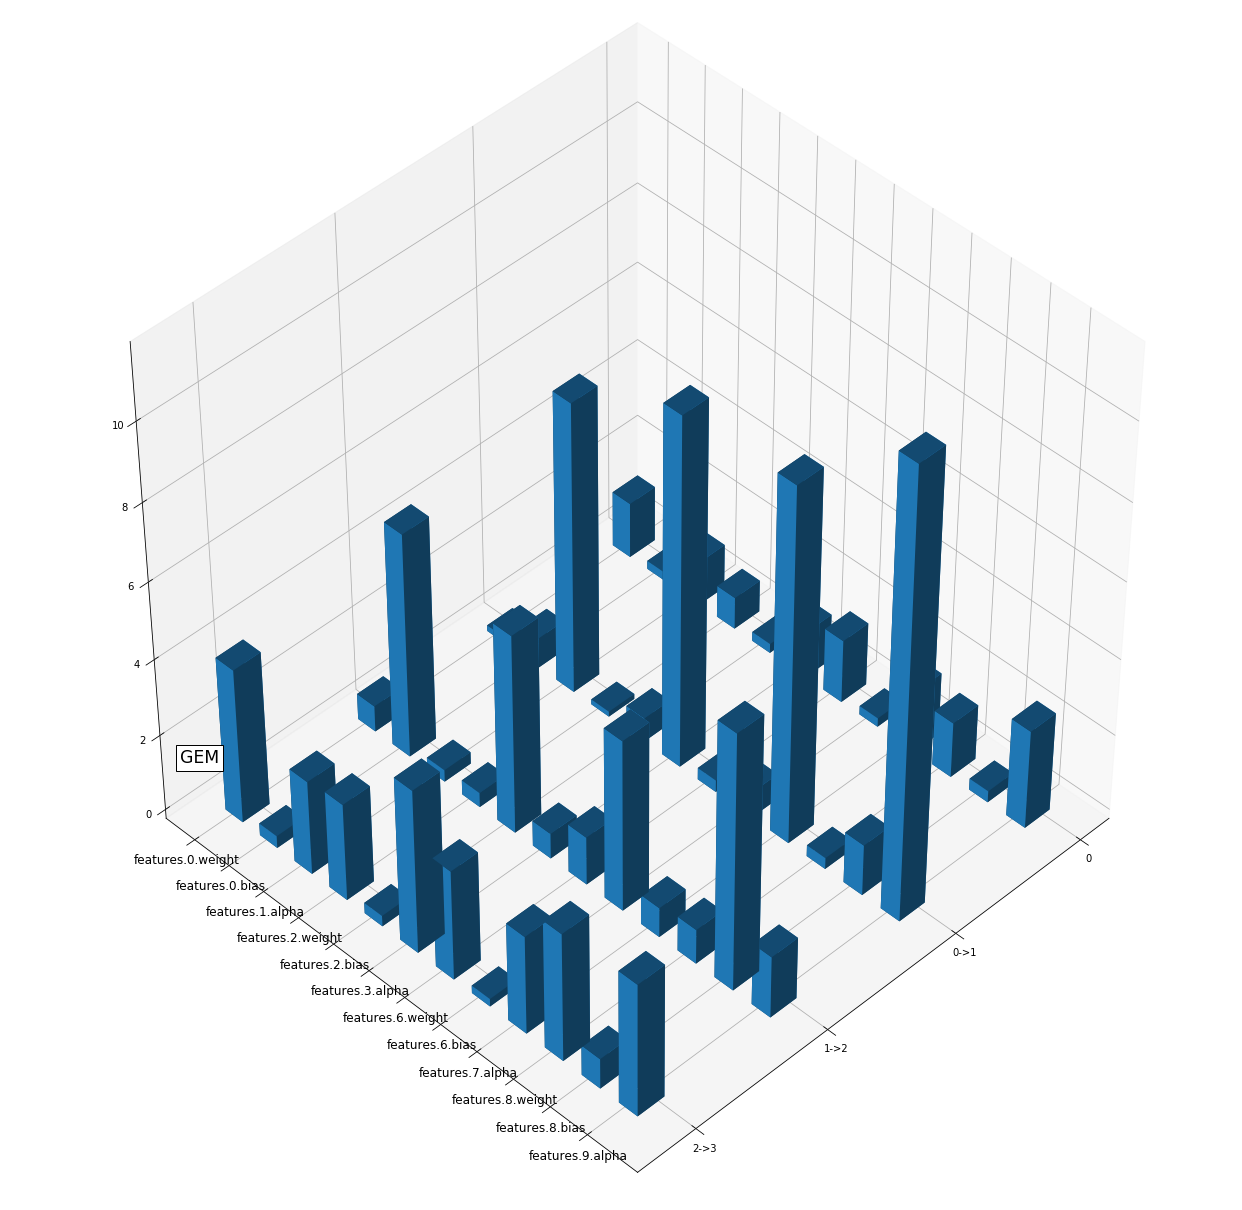

In [12]:
for name, tec in experiments:

    current_w = {n:p.cpu() for n, p in net.named_parameters() if p.requires_grad}

    x = np.arange(4)
    y = np.arange(len(current_w))
    
    xx, yy = np.meshgrid(x, y)
    z = np.zeros(shape=(len(x), len(y)))
    
    fig = plt.figure(figsize=(22, 22))
    ax = fig.add_subplot(111, projection='3d')
    
    x_labels = []
    
    for i in x:

        if i == 0:
            x_labels.append('0')
        else:
            x_labels.append('{}->{}'.format(i-1, i))
            
        n = deepcopy(net)
        c = deepcopy(config)

        c.MODEL_NAME = name

        if 'name' == 'gem':
            c.EWC_IMPORTANCE = 0.5

        c.EWC_TYPE = tec

        trainer = Trainer(n, deepcopy(dataset), c, save_modality=2)

        r = trainer.load(i)
        
        diff = {n: torch.dist(p.cpu(), current_w[n]) for n, p in trainer.model.named_parameters() if p.requires_grad }
        current_w = {n: p.cpu() for n, p in trainer.model.named_parameters() if p.requires_grad }
        
        for j, (_, d) in enumerate(diff.items()):
            z[i, j] = d
    

    z_n = z.flatten()

    ax.view_init(45, 45)
    
    ax.bar3d(xx.flatten(),
          yy.flatten(),
          np.zeros(len(z_n)),
          0.2, 0.5, z_n )
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    ax.set_yticks(y)
    ax.set_yticklabels(list(diff.keys()), fontdict={'fontsize':12})
    
    ax.text(3.5, 0, 2, name.upper(), color='black',  fontsize='xx-large', 
        bbox=dict(facecolor='white', edgecolor='black'))
    
    plt.show()

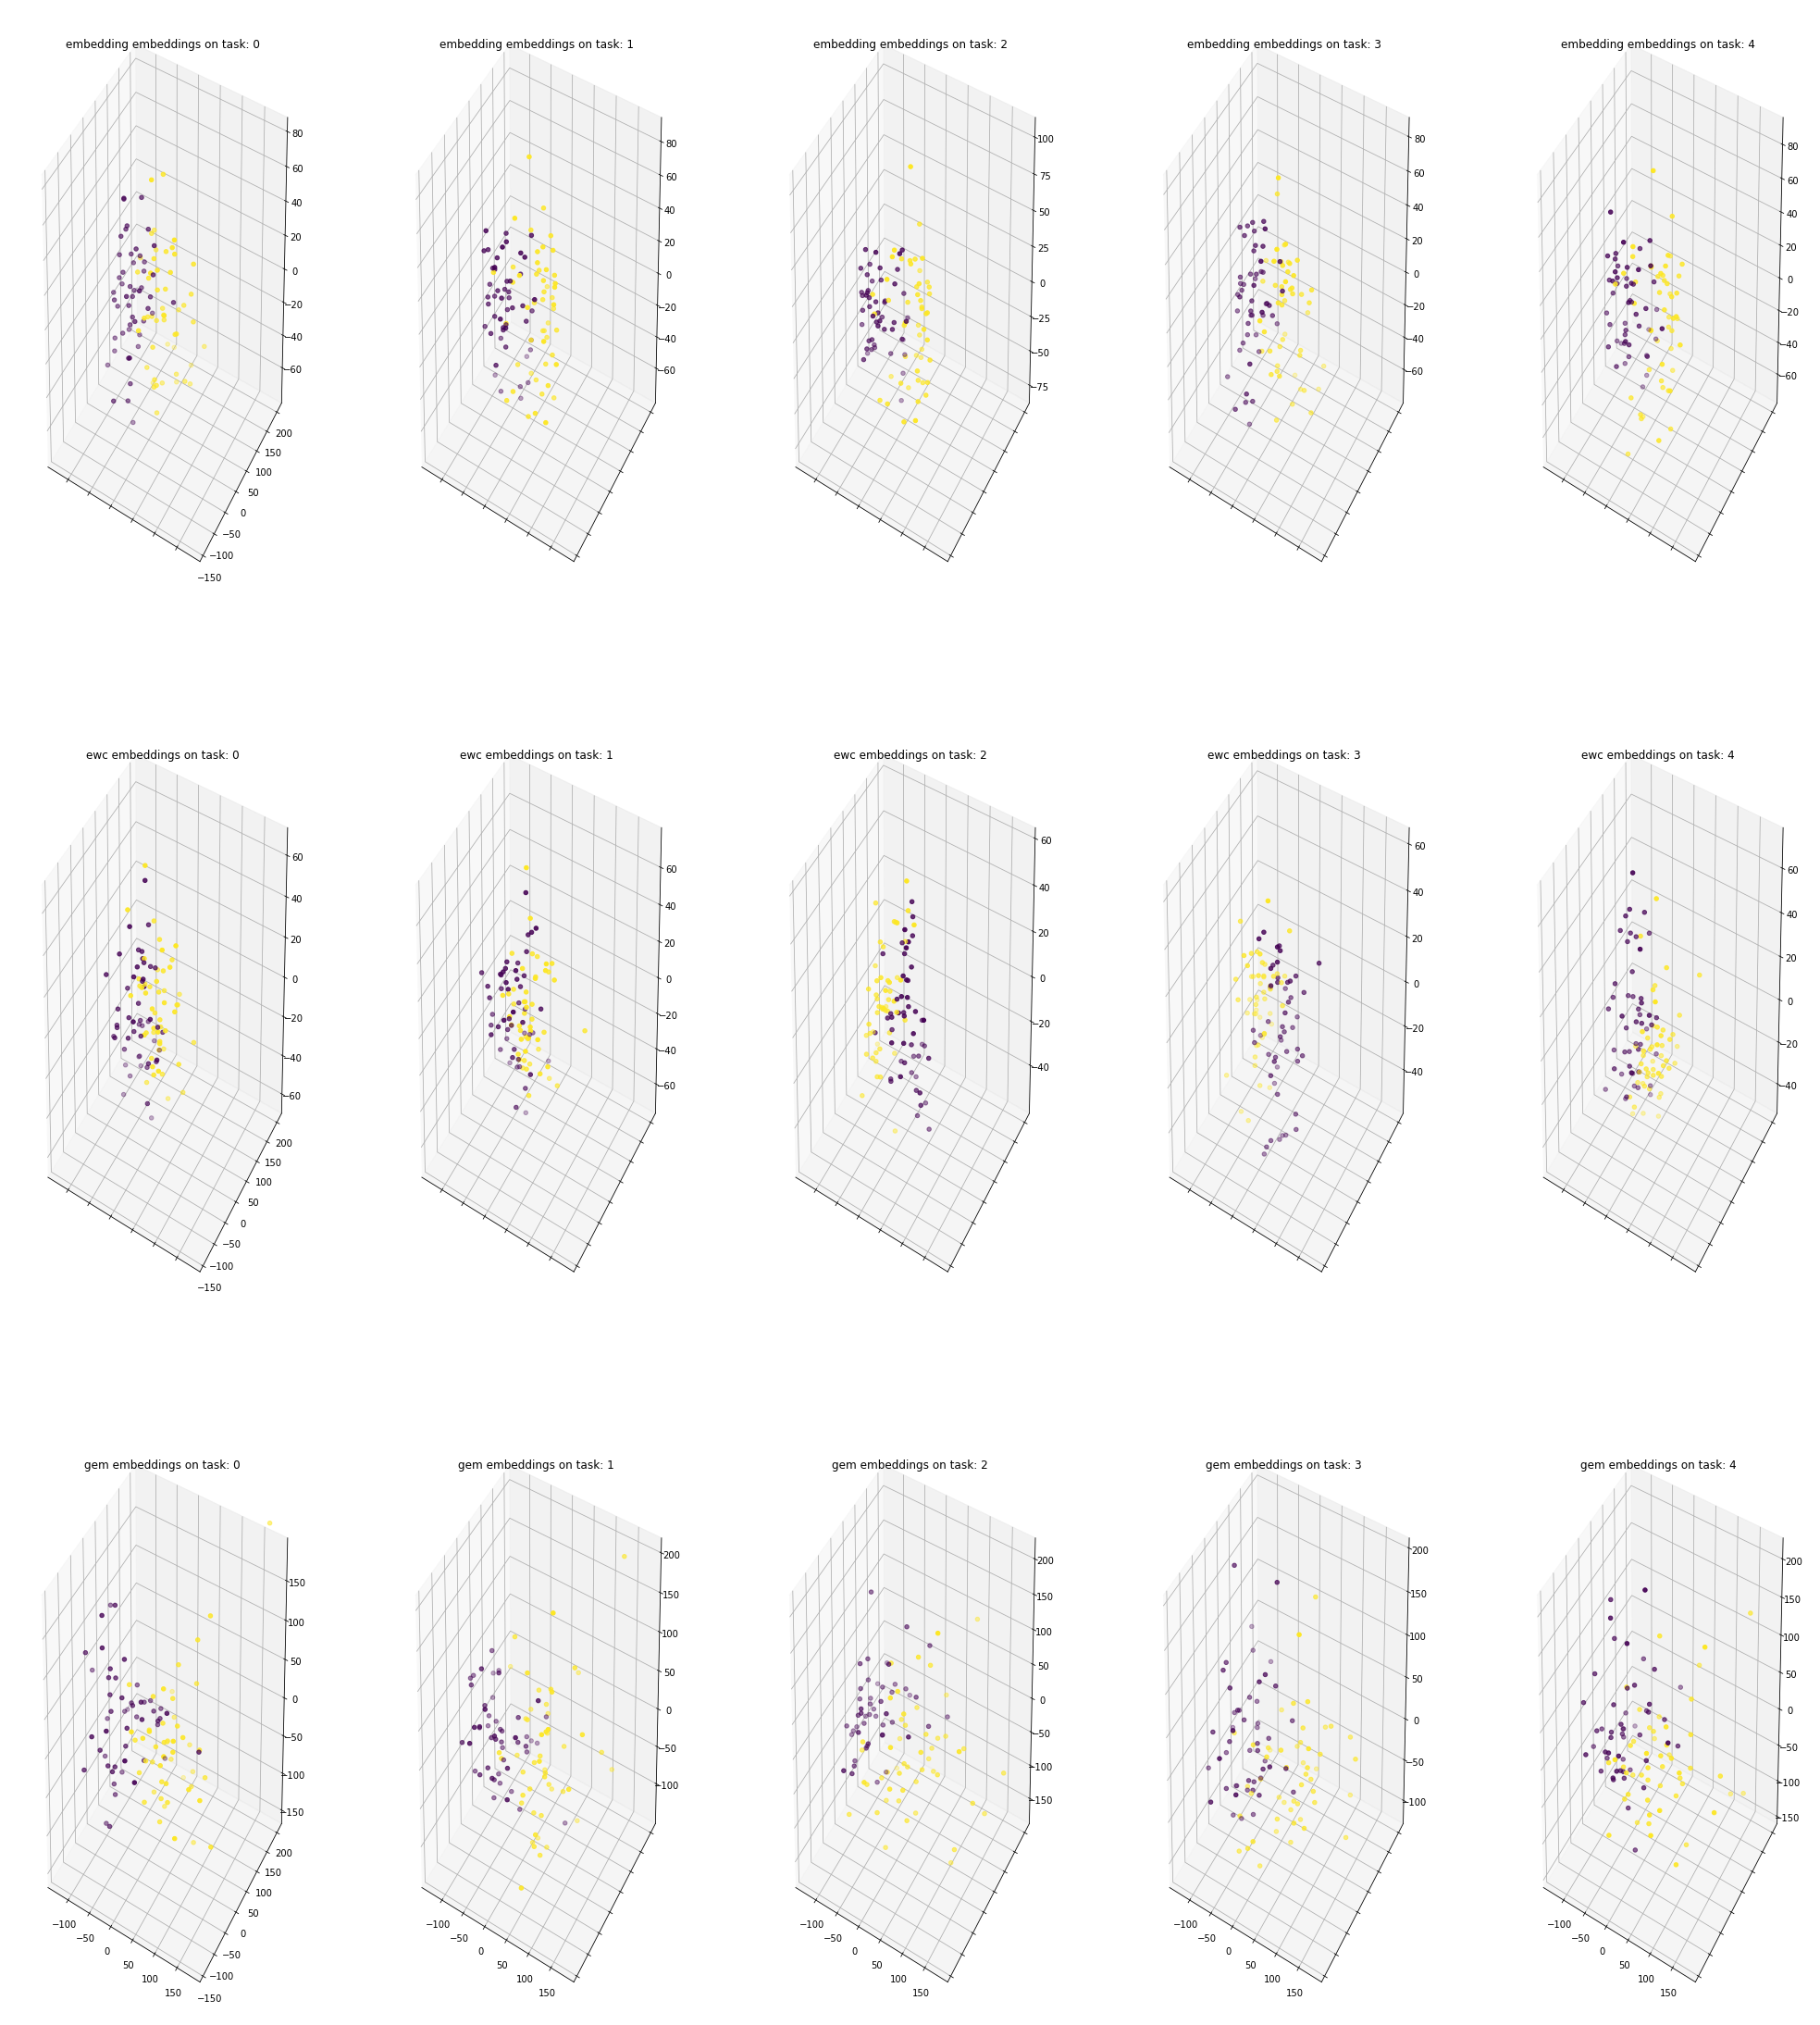

In [13]:
tot_epochs = 0

fig, ax = plt.subplots(nrows=len(experiments)-1, ncols=5, figsize=(35, 40), 
                       sharex=True, sharey=True,  subplot_kw={'projection':'3d'})

    
images_c = {}
images = []
labels = []

for k in range(5):
    dataset.task = k
        
    if k == 0:
        for im in range(len(dataset)):

            img, lbl = dataset[(im, dataset.task_mask(k))]
            lbl = lbl.numpy()[0]

            if lbl not in images_c:
                images_c[lbl] = 1
                images.append(img.numpy())
                labels.append(lbl)
            else:
                if images_c[lbl] < 50:
                    images.append(img.numpy())
                    images_c[lbl] = images_c[lbl] + 1
                    labels.append(lbl)
                
        colors = [int(i % 21) for i in labels]

    for i, (name, tec) in enumerate(experiments):
        
        if name == 'no_cont_learning':
            continue 
            
        tsne_model_en_2d = PCA(n_components=3, random_state=19)

        n = deepcopy(net)
        c = deepcopy(config)

        c.MODEL_NAME = name

        c.EWC_TYPE = tec

        trainer = Trainer(n, deepcopy(dataset), c, save_modality=2)
        
        r = trainer.load()
        trainer.model.task = 0

        a = trainer.model.embedding(torch.from_numpy(np.asarray(images)).to(config.DEVICE)).detach().cpu().numpy()
        b = tsne_model_en_2d.fit_transform(a)

        ax[i-1][k].scatter(b[:, 0], b[:, 1], b[:, 2], c=colors)
        ax[i-1][k].set_title("{} embeddings on task: {}".format(name, k))

        del trainer
        del n
plt.show()